# Pretraining on unlabeled data

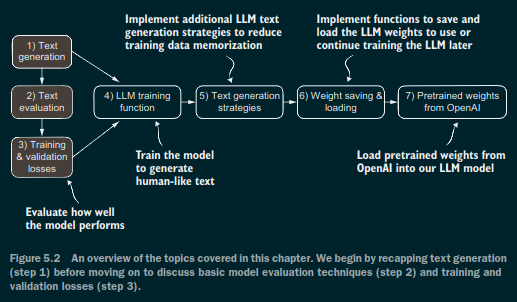

In [1]:
import torch
import nbimporter
from chp04_gpt_model import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False} 

torch.manual_seed(123) 
model = GPTModel(GPT_CONFIG_124M) 
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

# Calculating the text generation loss

Utility functions for text to token ID conversion

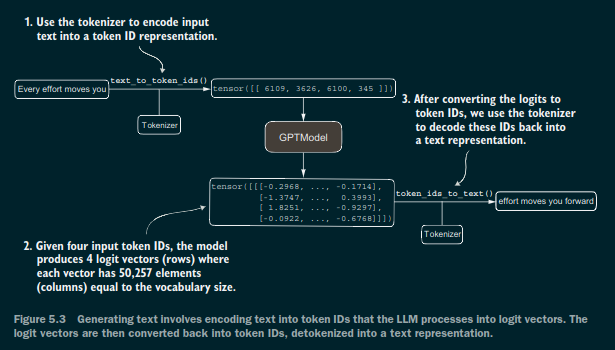

In [2]:
import tiktoken

# function to generate text using the model
def generate_text_simple(model, idx, max_new_tokens, context_size): 
    # to generate text upto max_new_tokens counts
    for _ in range(max_new_tokens): 
        # get the last context_size tokens
        idx_cond = idx[:, -context_size:] 
        with torch.no_grad(): 
            logits = model(idx_cond) 
        
        # get the last token logits which is models prediction
        logits = logits[:, -1, :] 
        probas = torch.softmax(logits, dim=-1) 
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) 
        idx = torch.cat((idx, idx_next), dim=1) 
        
    return idx

# function to covert text to token ids
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

# function to convert token ids to text
def token_ids_to_text(token_ids, tokenizer):
    return tokenizer.decode(token_ids.squeeze(0).tolist())

tokenizer = tiktoken.get_encoding("gpt2")

text_input = "Every effort moves you"
token_ids_input = text_to_token_ids(text_input,tokenizer)
token_ids_output = generate_text_simple(model,token_ids_input,10,GPT_CONFIG_124M["context_length"])
print("Output text : " + token_ids_to_text(token_ids_output,tokenizer))

Output text : Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## Making predictions

In [3]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]]) # "I really like"]

targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits , dim=-1)
print(probas.shape)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}") 
print(f"Outputs batch 1:" f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [4]:
probas[0]

tensor([[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05, 6.9776e-06,
         1.8776e-05],
        [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05, 6.0103e-06,
         1.3571e-05],
        [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05, 1.4094e-05,
         1.3526e-05]])

In [5]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] 
print("Text 1:", target_probas_1) 

text_idx = 1 
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]] 
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


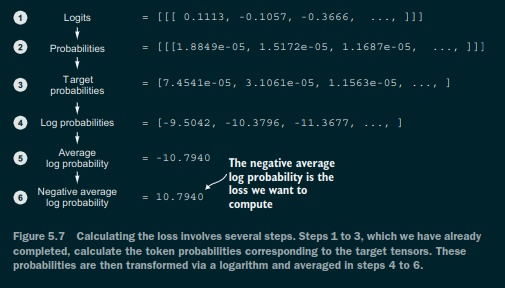

## Computing the loss

In [6]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2))) 
print(f"Log probabilites {log_probas}")

avg_log_probas = torch.mean(log_probas) 
print(f"Average of log proba {avg_log_probas}")

neg_avg_log_probas = avg_log_probas * -1 
print(f"Remove negative {neg_avg_log_probas}")

Log probabilites tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
Average of log proba -10.793964385986328
Remove negative 10.793964385986328


In [7]:
print("Logits shape:", logits.shape) 
print("Targets shape:", targets.shape)

logits_flat = logits.flatten(0, 1) 
targets_flat = targets.flatten() 
print("Flattened logits:", logits_flat.shape) 
print("Flattened targets:", targets_flat.shape)

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat) 
print(loss)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.7940)


# Calculating the training and validation set losses

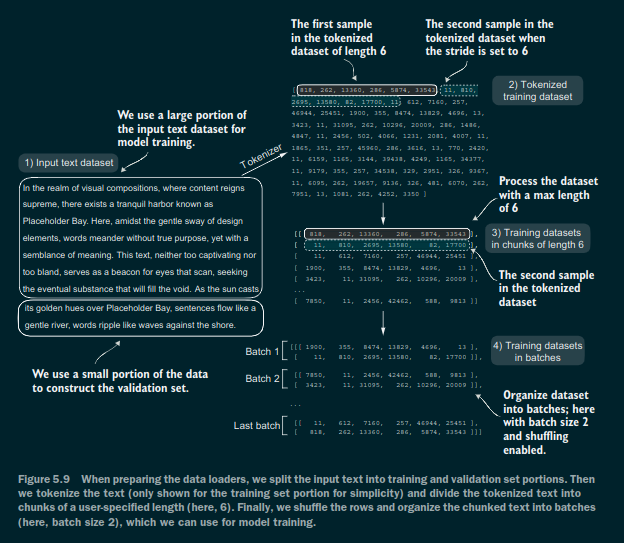

In [8]:
file_path = "the-verdict.txt"
with open(file_path,"r",encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data)) 
print("Characters ", total_characters)
print("Tokens ",total_tokens)

Characters  20479
Tokens  5145


In [9]:
# Splitting data into train and validation sets

train_ratio = 90
split_idx = int(len(text_data) * 90 / 100)

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(f"Train size {len(train_data)} , Val size {len(val_data)}")

Train size 18431 , Val size 2048


In [10]:
import torch
from torch.utils.data import DataLoader, Dataset

class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, context_len, skips):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(text)

        for i in range(0, len(token_ids) - context_len, skips):
            self.input_ids.append(torch.tensor(token_ids[i : i + context_len], dtype=torch.long))
            self.target_ids.append(torch.tensor(token_ids[i + 1 : i + context_len + 1], dtype=torch.long))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index] , self.target_ids[index]
    
tokenizer = tiktoken.get_encoding("gpt2")
context_len=GPT_CONFIG_124M["context_length"]
skips=GPT_CONFIG_124M["context_length"]

train_loader = DataLoader(
    GPTDataset(train_data,tokenizer,context_len,skips),
    batch_size=2,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    GPTDataset(val_data,tokenizer,context_len,skips),
    batch_size=2,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

print("Train data loader")
for x , y in train_loader:
    print(x.shape, y.shape)

print("\nValidation data loader")
for x , y in val_loader:
    print(x.shape, y.shape)

Train data loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation data loader
torch.Size([2, 256]) torch.Size([2, 256])


In [11]:
# Function to compute the training and validation loss

def calc_loss_batch(input_batch, target_batch, model, device): 
    input_batch = input_batch.to(device) 
    target_batch = target_batch.to(device) 
    logits = model(input_batch) 
    loss = torch.nn.functional.cross_entropy( logits.flatten(0, 1), target_batch.flatten()) 
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0. 
    if len(data_loader) == 0: 
        return float("nan") 
    elif num_batches is None:
        num_batches = len(data_loader) 
    else: num_batches = min(num_batches, len(data_loader)) 
    
    for i, (input_batch, target_batch) in enumerate(data_loader): 
        if i < num_batches: 
            loss = calc_loss_batch( input_batch, target_batch, model, device) 
            total_loss += loss.item() 
        else: break 
    return total_loss / num_batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device) 
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device) 
    val_loss = calc_loss_loader(val_loader, model, device) 
    
print("Training loss:", train_loss) 
print("Validation loss:", val_loss)

Training loss: 10.987583796183268
Validation loss: 10.981106758117676


In [12]:
def generate_and_print_sample(model, tokenizer, device, start_context): 
    model.eval() 
    context_size = model.pos_emb.weight.shape[0] 
    encoded = text_to_token_ids(start_context, tokenizer).to(device) 
    with torch.no_grad(): 
        token_ids = generate_text_simple( 
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        ) 
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) 
    model.train()

def evaluate_model(model, train_loader, val_loader, device, eval_iter): 
    # During evaluation dropout is disabled
    model.eval() 
    # Disables gradient tracking which is not required during evaluation
    with torch.no_grad(): 
        train_loss = calc_loss_loader( train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader( val_loader, model, device, num_batches=eval_iter)

    model.train() 
    return train_loss, val_loss

# The main function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader, 
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], [] 
    tokens_seen, global_step = 0, -1

    # start the main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            # Reset the loss gradients from the previous batch iteration
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            # Calculates the loss gradients
            loss.backward()
            # update the weights
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model( model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss) 
                val_losses.append(val_loss) 
                track_tokens_seen.append(tokens_seen) 
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")
        
        generate_and_print_sample( model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

In [13]:
torch.manual_seed(123) 
model = GPTModel(GPT_CONFIG_124M) 
model.to(device) 
optimizer = torch.optim.AdamW( model.parameters(), lr=0.0004, weight_decay=0.1) 

num_epochs = 10 
train_losses, val_losses, tokens_seen = train_model_simple( 
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=5, 
    start_context="Every effort moves you", tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 8.050, Val loss 8.333
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.758, Val loss 7.046
Ep 2 (Step 000015): Train loss 6.142, Val loss 6.630
Every effort moves you, and, and, and, and, and, and, and.                                   
Ep 3 (Step 000020): Train loss 13.925, Val loss 14.195
Ep 3 (Step 000025): Train loss 5.513, Val loss 6.420
Every effort moves you, and to the"                                             
Ep 4 (Step 000030): Train loss 5.165, Val loss 6.381
Ep 4 (Step 000035): Train loss 4.753, Val loss 6.316
Every effort moves you.                           "I"I"I"I it's"I"I"I"I"I"I
Ep 5 (Step 000040): Train loss 4.627, Val loss 6.394
Every effort moves you, I had been.                       "II me, and he had the donkey.           
Ep 6 (Step 000045): Train loss 4.026, Val loss 6.260
Ep 6 (Step 000050): Train loss 3.541, Val lo

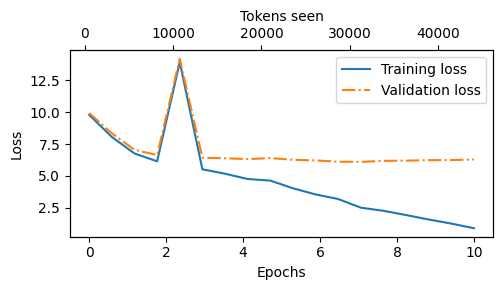

In [14]:
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator 
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses): 
    fig, ax1 = plt.subplots(figsize=(5, 3)) 
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot( epochs_seen, val_losses, linestyle="-.", label="Validation loss") 
    ax1.set_xlabel("Epochs") 
    ax1.set_ylabel("Loss") 
    ax1.legend(loc="upper right") 
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) 
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen") 
    fig.tight_layout() 
    plt.show() 

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Decoding strategies to control randomness

In [15]:
model.to("cpu") 
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
     model=model, idx=text_to_token_ids("Every effort moves you", tokenizer),
     max_new_tokens=25, context_size=GPT_CONFIG_124M["context_length"]
    ) 

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the picture for nothing--I told Mrs.
"Oh, my work, and went on grop


### Temperature Scaling

In the step of generating text instead of using argmax function torch multinomial function is used. 

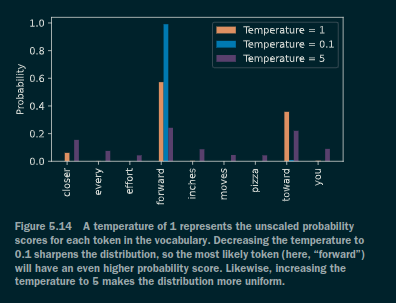

In [16]:
vocab = {"closer": 0,"every": 1,"effort": 2,"forward": 3,"inches": 4,"moves": 5,"pizza": 6,"toward": 7,"you": 8,} 
inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probas = torch.softmax(next_token_logits, dim=0) 
next_token_id = torch.argmax(probas).item() 
print(inverse_vocab[next_token_id])

def print_sampled_tokens(probas): 
    torch.manual_seed(123) 
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)] 
    sampled_ids = torch.bincount(torch.tensor(sample)) 
    for i, freq in enumerate(sampled_ids): print(f"{freq} x {inverse_vocab[i]}") 

print_sampled_tokens(probas)

forward
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


### Top-k sampling

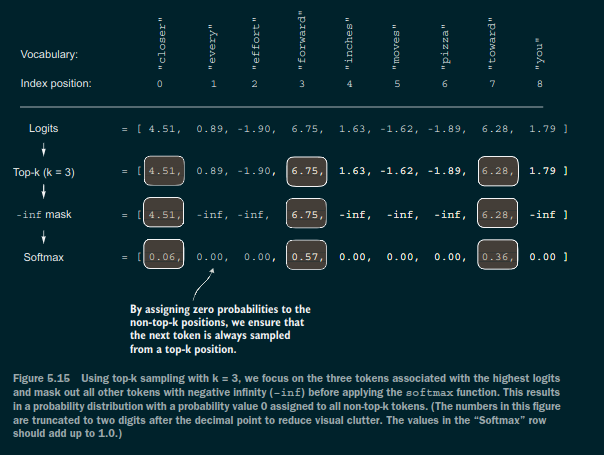

In [17]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k) 
print("Top logits:", top_logits) 
print("Top positions:", top_pos)

new_logits = torch.where( condition=next_token_logits < top_logits[-1], 
                         input=torch.tensor(float('-inf')), 
                         other=next_token_logits)
print(new_logits)

topk_probas = torch.softmax(new_logits, dim=0) 
print(topk_probas)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Modifying the text generation function

In [18]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens): 
        idx_cond = idx[:, -context_size:] 
        with torch.no_grad(): 
            logits = model(idx_cond) 
        logits = logits[:, -1, :]

        # Filter top k samples 
        if top_k is not None: 
            top_logits, _ = torch.topk(logits, top_k) 
            min_val = top_logits[:, -1] 
            logits = torch.where( logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # apply temperature scaling 
        if temperature > 0.0: 
            logits = logits / temperature 
            probs = torch.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1) 
        else: 
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) 
            
        # stops generating tokens when End of sentences is encountered
        if idx_next == eos_id: 
            break 
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

torch.manual_seed(123) 
token_ids = generate( 
    model=model, 
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"], 
    top_k=25,
    temperature=1.4
) 

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a little wild--I was such a laugh; and


# Loading and saving model weights in PyTorch

In [19]:
# Saving the model
torch.save(model.state_dict(), "model.pth")

In [20]:
# Loading the model
model = GPTModel(GPT_CONFIG_124M) 
model.load_state_dict(torch.load("model.pth", map_location=device)) 
model.eval()

/tmp/ipykernel_12504/3347774290.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=device))


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### Saving both Optimzer and model parameters

In [21]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [22]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device) 
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"]) 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1) 
optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) 
model.train();

/tmp/ipykernel_12504/2615302999.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


# Loading pretrained weights from OpenAI

In [23]:
# Downloads python code which helps in model loading
import urllib.request 
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
    ) 

filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x792ee9a02690>)

In [24]:
# Use the download python code to load the GPT2 model 
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2( model_size="124M", models_dir="gpt2")

2025-05-23 14:52:45.033494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747992166.609871   12504 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747992166.864736   12504 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747992169.192850   12504 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747992169.192866   12504 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747992169.192867   12504 computation_placer.cc:177] computation placer alr

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-05-23 14:54:47.171418: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


In [25]:
print("Settings:", settings) 
print("Parameter dictionary keys:", params.keys())

# inspecting the weight parameters
print("Settings:", settings) 
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


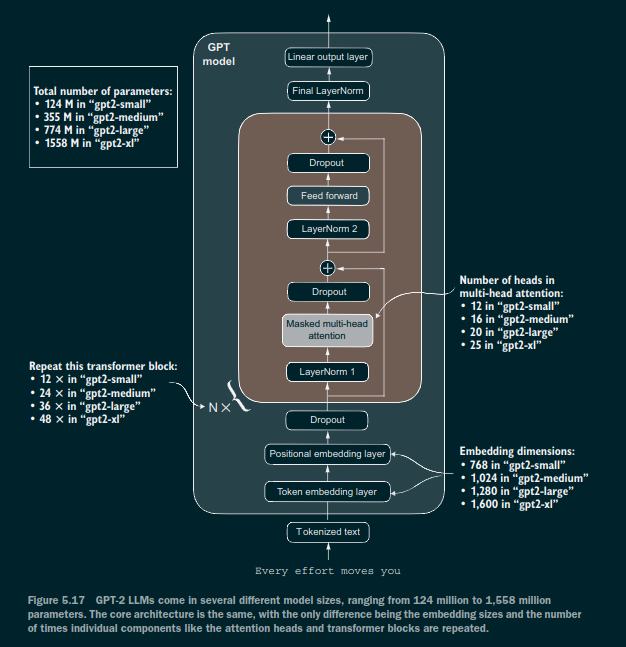

In [26]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy() 
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

gpt = GPTModel(NEW_CONFIG) 
gpt.eval()

def assign(left, right): 
    if left.shape != right.shape: 
        raise ValueError(f"Shape mismatch. Left: {left.shape}, ""Right: {right.shape}") 
    return torch.nn.Parameter(torch.tensor(right))

In [27]:
import numpy as np 
def load_weights_into_gpt(gpt, params):
    # Sets models positional and token embeding weights to those specified in params
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe']) 
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1) 
        gpt.trf_blocks[b].att.W_query.weight = assign( 
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
             gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
             gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1) 
        gpt.trf_blocks[b].att.W_query.bias = assign( 
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign( 
            gpt.trf_blocks[b].att.W_key.bias, k_b) 
        gpt.trf_blocks[b].att.W_value.bias = assign( 
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        gpt.trf_blocks[b].att.out_proj.weight = assign( 
            gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign( 
            gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign( 
            gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T) 
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"]) 
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T) 
        gpt.trf_blocks[b].ff.layers[2].bias = assign( 
            gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"]) 
        gpt.trf_blocks[b].norm1.shift = assign( 
            gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"]) 
        gpt.trf_blocks[b].norm2.scale = assign( 
            gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"]) 
        gpt.trf_blocks[b].norm2.shift = assign( 
            gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])
        
gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"]) 
gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"]) 
gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [28]:
load_weights_into_gpt(gpt, params) 
gpt.to(device)

torch.manual_seed(123) 
token_ids = generate( 
    model=gpt, 
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25, 
    context_size=NEW_CONFIG["context_length"], 
    top_k=50, temperature=1.5
) 

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
